In [1]:
import os
filename = "/root/.kaggle/"
os.makedirs(os.path.dirname(filename), exist_ok=True)

In [2]:
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle_api/kaggle.json' "/root/.kaggle"

In [3]:
!kaggle datasets download -d aadilmalik94/animecharacterfaces

 98% 748M/760M [00:22<00:00, 40.9MB/s]
100% 760M/760M [00:22<00:00, 35.1MB/s]


In [4]:
!unzip animecharacterfaces.zip

Streaming output truncated to the last 5000 lines.
  inflating: animeface-character-dataset/data/face_323_149_22.png  
  inflating: animeface-character-dataset/data/face_323_149_25.png  
  inflating: animeface-character-dataset/data/face_323_149_32.png  
  inflating: animeface-character-dataset/data/face_323_149_38.png  
  inflating: animeface-character-dataset/data/face_323_149_56.png  
  inflating: animeface-character-dataset/data/face_323_149_7.png  
  inflating: animeface-character-dataset/data/face_323_149_81.png  
  inflating: animeface-character-dataset/data/face_323_174_148.png  
  inflating: animeface-character-dataset/data/face_323_174_151.png  
  inflating: animeface-character-dataset/data/face_323_174_154.png  
  inflating: animeface-character-dataset/data/face_323_174_44.png  
  inflating: animeface-character-dataset/data/face_323_174_52.png  
  inflating: animeface-character-dataset/data/face_323_174_54.png  
  inflating: animeface-character-dataset/data/face_323_174_92.p

In [5]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

In [6]:
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,LeakyReLU,Conv2DTranspose,Input,Reshape,Conv2D,ReLU
from tensorflow.keras.layers import Reshape,Activation,UpSampling2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from sklearn.utils import shuffle
import glob

In [8]:
np.random.seed(177013)

In [9]:
def gen_normal(noise_shape):
    
    kernel_init = 'glorot_uniform'
    
    gen_input = Input(shape = noise_shape)
    generator = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = (1,1), padding = "valid", data_format = "channels_last", kernel_initializer = kernel_init)(gen_input)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
        
    generator = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2DTranspose(filters = 3, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = Activation('tanh')(generator)
        
    gen_opt = Adam(lr=0.00015, beta_1=0.5)
    generator_model = Model(gen_input,generator,name = "Generator")
    generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])

    return generator_model

In [10]:
def dis_normal(image_shape=(64,64,3)):
    
    dropout_prob = 0.4
    kernel_init = 'glorot_uniform'
    dis_input = Input(shape = image_shape)
    discriminator = Conv2D(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(dis_input)
    discriminator = LeakyReLU(0.2)(discriminator)
    discriminator = Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
   
    discriminator = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    
    discriminator = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    
    discriminator = Flatten()(discriminator)
    
    discriminator = Dense(1)(discriminator)
    discriminator = Activation('sigmoid')(discriminator)
    #also try the SGD optimiser, might work better for a few learning rates.
    dis_opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator_model = Model(dis_input,discriminator,name = "Discriminator")
    discriminator_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])
    return discriminator_model

In [11]:
def norm_img(img):
    img = (img / 127.5) - 1
    #image normalisation to keep values between -1 and 1 for stability
    return img

def denorm_img(img):
    #for output
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 

In [12]:
def sample_from_dataset(batch_size, image_shape, data_dir=None, data = None):
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB')
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample

In [13]:
def gen_noise(batch_size, noise_shape):
    #input noise for the generator should follow a probability distribution, like in this case, the normal distributon.
    return np.random.normal(0, 1, size=(batch_size,)+noise_shape)

In [14]:
def generate_images(generator, save_dir):
    
    noise = gen_noise(batch_size,noise_shape)
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(4,4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()

In [15]:
def save_img_batch(img_batch,img_save_dir):
    plt.figure(figsize=(4,4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
    plt.show()   

In [16]:
!mkdir /content/gan_images/
!mkdir /content/checkpoints/

In [26]:
noise_shape = (1,1,100)
num_steps = 50000
batch_size = 64
image_shape = None
img_save_dir = "/content/gan_images/"
save_model = True
image_shape = (64,64,3)
data_dir =  "/content/animeface-character-dataset/animeface-character-dataset/data/*"
log_dir = img_save_dir
save_model_dir = "/content/checkpoints/"

In [18]:
discriminator = dis_normal(image_shape)
generator = gen_normal(noise_shape)

In [19]:
discriminator.trainable = False

opt = Adam(lr=0.00015, beta_1=0.5) 
gen_inp = Input(shape=noise_shape)
GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)
gan = Model(gen_inp,GAN_opt)
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

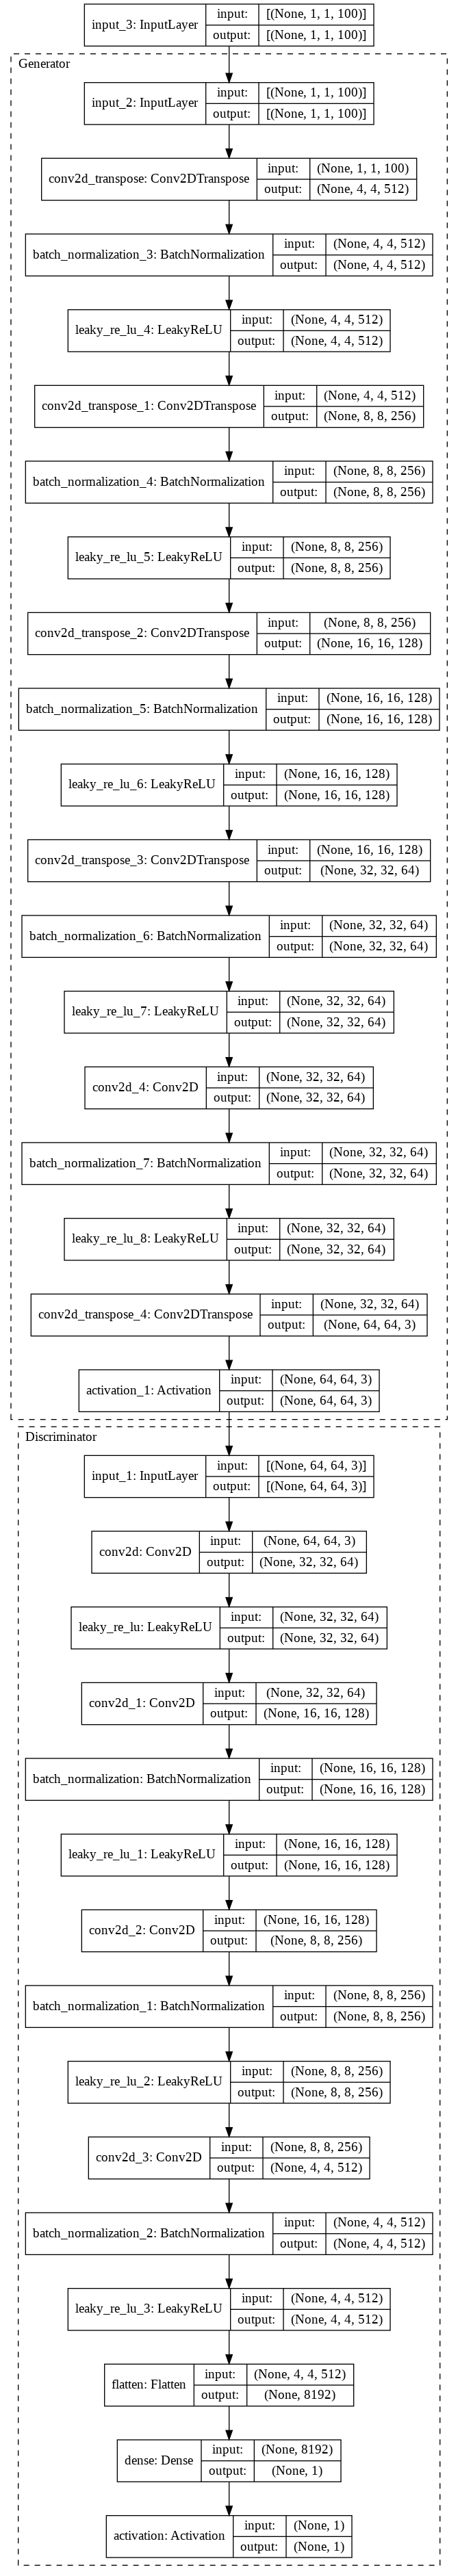

In [20]:
tensorflow.keras.utils.plot_model(gan,show_shapes = True,expand_nested=True)

In [21]:
avg_disc_fake_loss = deque([0], maxlen=250)     
avg_disc_real_loss = deque([0], maxlen=250)
avg_GAN_loss = deque([0], maxlen=250)

In [22]:
import time
from PIL import Image
import matplotlib.gridspec as gridspec

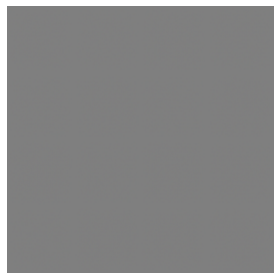

Epoch : 0/50000  D-loss-Fake : 3.0805530548095703 D-loss :0.7050307989120483 G-loss : 0.7960389852523804 time_taken : 9 secs
Epoch : 500/50000  D-loss-Fake : 0.30781081318855286 D-loss :0.3264244496822357 G-loss : 0.3233999013900757 time_taken : 0 secs


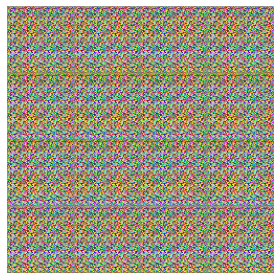

Epoch : 1000/50000  D-loss-Fake : 0.30728891491889954 D-loss :0.3425178825855255 G-loss : 0.3437875211238861 time_taken : 1 secs
Epoch : 1500/50000  D-loss-Fake : 0.37191006541252136 D-loss :0.34133023023605347 G-loss : 0.334746778011322 time_taken : 0 secs


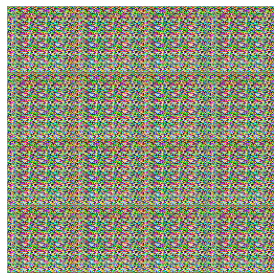

Epoch : 2000/50000  D-loss-Fake : 0.3441135883331299 D-loss :0.325487345457077 G-loss : 0.3326115608215332 time_taken : 1 secs
Epoch : 2500/50000  D-loss-Fake : 0.33177292346954346 D-loss :0.33517205715179443 G-loss : 0.361031711101532 time_taken : 0 secs


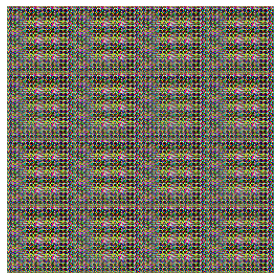

Epoch : 3000/50000  D-loss-Fake : 0.3416171669960022 D-loss :0.3534453213214874 G-loss : 0.3429272770881653 time_taken : 1 secs
Epoch : 3500/50000  D-loss-Fake : 0.33475610613822937 D-loss :0.2982131242752075 G-loss : 0.2968848943710327 time_taken : 0 secs


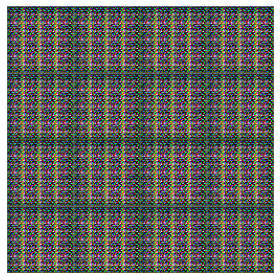

Epoch : 4000/50000  D-loss-Fake : 0.3369264006614685 D-loss :0.29896706342697144 G-loss : 0.3013785481452942 time_taken : 1 secs
Epoch : 4500/50000  D-loss-Fake : 0.3163265287876129 D-loss :0.3442409634590149 G-loss : 0.34310150146484375 time_taken : 0 secs


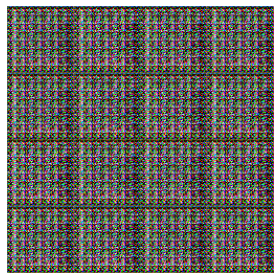

Epoch : 5000/50000  D-loss-Fake : 0.36851897835731506 D-loss :0.3464411199092865 G-loss : 0.3469904065132141 time_taken : 1 secs
Epoch : 5500/50000  D-loss-Fake : 0.345386803150177 D-loss :0.3185957670211792 G-loss : 0.3188663423061371 time_taken : 0 secs


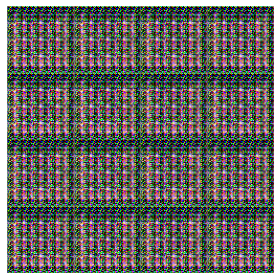

Epoch : 6000/50000  D-loss-Fake : 0.3141695261001587 D-loss :0.3152680993080139 G-loss : 0.34625643491744995 time_taken : 1 secs
Epoch : 6500/50000  D-loss-Fake : 0.3462114632129669 D-loss :0.3257157802581787 G-loss : 0.34032243490219116 time_taken : 0 secs


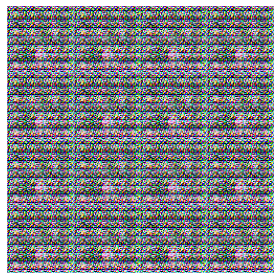

Epoch : 7000/50000  D-loss-Fake : 0.3188702464103699 D-loss :0.3424837291240692 G-loss : 0.35823968052864075 time_taken : 1 secs
Epoch : 7500/50000  D-loss-Fake : 0.33631056547164917 D-loss :0.34802648425102234 G-loss : 0.38498783111572266 time_taken : 0 secs


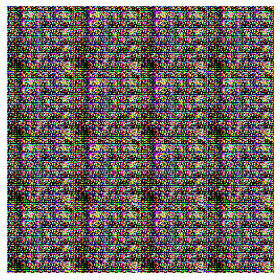

Epoch : 8000/50000  D-loss-Fake : 0.30484598875045776 D-loss :0.3031952977180481 G-loss : 0.3877798020839691 time_taken : 1 secs
Epoch : 8500/50000  D-loss-Fake : 0.32482677698135376 D-loss :0.32230377197265625 G-loss : 0.3847240209579468 time_taken : 0 secs


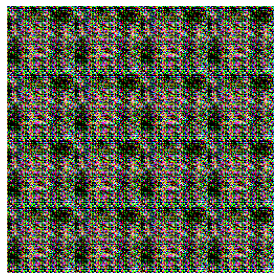

Epoch : 9000/50000  D-loss-Fake : 0.3182152807712555 D-loss :0.3154081404209137 G-loss : 0.42797911167144775 time_taken : 1 secs
Epoch : 9500/50000  D-loss-Fake : 0.3148044943809509 D-loss :0.31540626287460327 G-loss : 0.42166754603385925 time_taken : 0 secs
-----------------------------------------------------------------
Average Disc_fake loss: 0.327485
Average Disc_real loss: 0.327677
Average GAN loss: 0.370555
-----------------------------------------------------------------


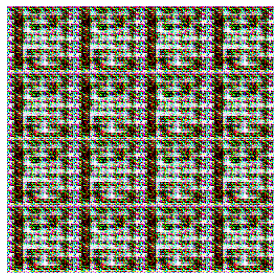

Epoch : 10000/50000  D-loss-Fake : 0.36051928997039795 D-loss :0.3483530282974243 G-loss : 0.37342533469200134 time_taken : 1 secs
Epoch : 10500/50000  D-loss-Fake : 0.2957633435726166 D-loss :0.33017218112945557 G-loss : 0.4837786555290222 time_taken : 0 secs


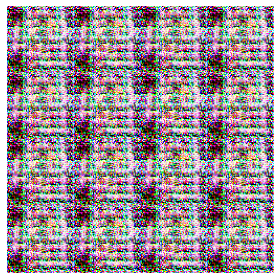

Epoch : 11000/50000  D-loss-Fake : 0.3204207718372345 D-loss :0.30473172664642334 G-loss : 0.41931819915771484 time_taken : 1 secs
Epoch : 11500/50000  D-loss-Fake : 0.3377808928489685 D-loss :0.32262277603149414 G-loss : 0.43839532136917114 time_taken : 0 secs


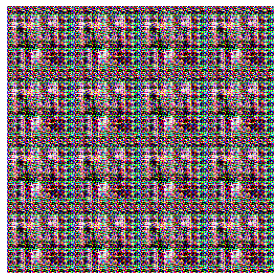

Epoch : 12000/50000  D-loss-Fake : 0.31923824548721313 D-loss :0.3074987530708313 G-loss : 0.31873756647109985 time_taken : 1 secs
Epoch : 12500/50000  D-loss-Fake : 0.3406495451927185 D-loss :0.32824915647506714 G-loss : 0.3662753701210022 time_taken : 0 secs


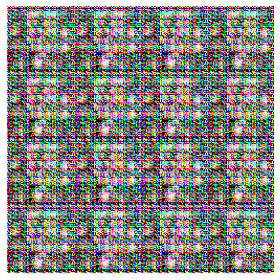

Epoch : 13000/50000  D-loss-Fake : 0.3350224494934082 D-loss :0.33308184146881104 G-loss : 0.4115019738674164 time_taken : 1 secs
Epoch : 13500/50000  D-loss-Fake : 0.34430041909217834 D-loss :0.3222956657409668 G-loss : 0.43227648735046387 time_taken : 0 secs


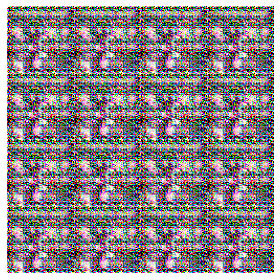

Epoch : 14000/50000  D-loss-Fake : 0.327210396528244 D-loss :0.3296050727367401 G-loss : 0.45480531454086304 time_taken : 1 secs
Epoch : 14500/50000  D-loss-Fake : 0.30394208431243896 D-loss :0.3210298717021942 G-loss : 0.4744377136230469 time_taken : 0 secs


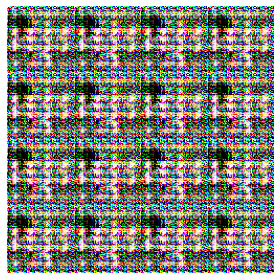

Epoch : 15000/50000  D-loss-Fake : 0.3036484718322754 D-loss :0.3173729479312897 G-loss : 0.4745869040489197 time_taken : 1 secs
Epoch : 15500/50000  D-loss-Fake : 0.32263126969337463 D-loss :0.3266832232475281 G-loss : 0.48917579650878906 time_taken : 0 secs


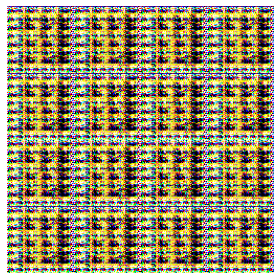

Epoch : 16000/50000  D-loss-Fake : 0.34628087282180786 D-loss :0.33176523447036743 G-loss : 0.33724868297576904 time_taken : 1 secs
Epoch : 16500/50000  D-loss-Fake : 0.3599388301372528 D-loss :0.32386311888694763 G-loss : 0.3734065890312195 time_taken : 0 secs


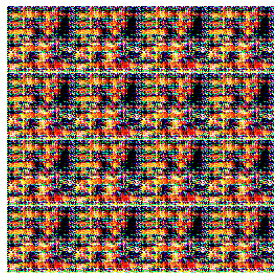

Epoch : 17000/50000  D-loss-Fake : 0.3226057291030884 D-loss :0.33678966760635376 G-loss : 0.3995705842971802 time_taken : 1 secs
Epoch : 17500/50000  D-loss-Fake : 0.34838351607322693 D-loss :0.31735244393348694 G-loss : 0.46961408853530884 time_taken : 0 secs


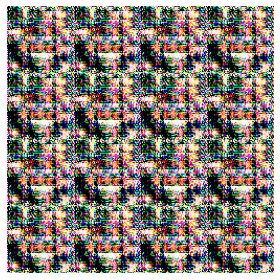

Epoch : 18000/50000  D-loss-Fake : 0.3178717792034149 D-loss :0.355500191450119 G-loss : 0.45230644941329956 time_taken : 1 secs
Epoch : 18500/50000  D-loss-Fake : 0.3755873441696167 D-loss :0.33007365465164185 G-loss : 0.4079238176345825 time_taken : 0 secs


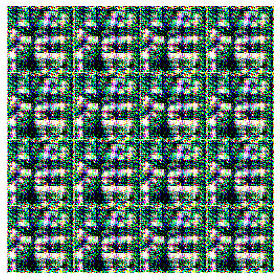

Epoch : 19000/50000  D-loss-Fake : 0.3212742805480957 D-loss :0.35931652784347534 G-loss : 0.47700637578964233 time_taken : 1 secs
Epoch : 19500/50000  D-loss-Fake : 0.32498836517333984 D-loss :0.3465353846549988 G-loss : 0.4583912193775177 time_taken : 0 secs
-----------------------------------------------------------------
Average Disc_fake loss: 0.335546
Average Disc_real loss: 0.327366
Average GAN loss: 0.462030
-----------------------------------------------------------------


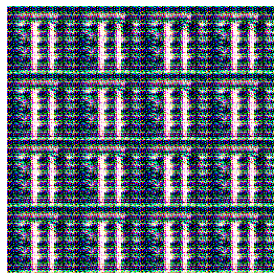

Epoch : 20000/50000  D-loss-Fake : 0.31436237692832947 D-loss :0.3423188328742981 G-loss : 0.474209189414978 time_taken : 1 secs
Epoch : 20500/50000  D-loss-Fake : 0.3200492262840271 D-loss :0.3322911262512207 G-loss : 0.46734148263931274 time_taken : 0 secs


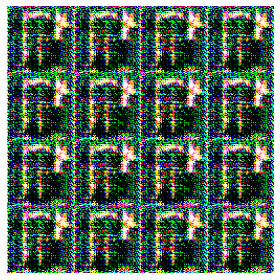

Epoch : 21000/50000  D-loss-Fake : 0.3233603239059448 D-loss :0.32419711351394653 G-loss : 0.46867769956588745 time_taken : 1 secs
Epoch : 21500/50000  D-loss-Fake : 0.3319058120250702 D-loss :0.3241221308708191 G-loss : 0.4622250497341156 time_taken : 0 secs


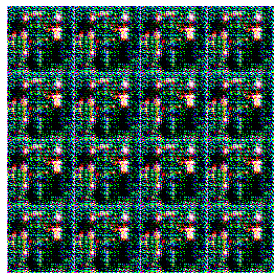

Epoch : 22000/50000  D-loss-Fake : 0.30191469192504883 D-loss :0.3416309356689453 G-loss : 0.4800627827644348 time_taken : 1 secs
Epoch : 22500/50000  D-loss-Fake : 0.302945077419281 D-loss :0.338509202003479 G-loss : 0.5189852714538574 time_taken : 0 secs


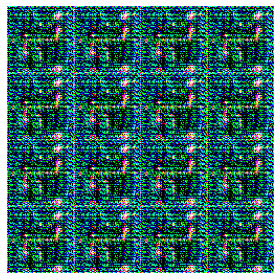

Epoch : 23000/50000  D-loss-Fake : 0.3042271137237549 D-loss :0.3247748911380768 G-loss : 0.45056629180908203 time_taken : 1 secs
Epoch : 23500/50000  D-loss-Fake : 0.32236069440841675 D-loss :0.3115609288215637 G-loss : 0.4077792167663574 time_taken : 0 secs


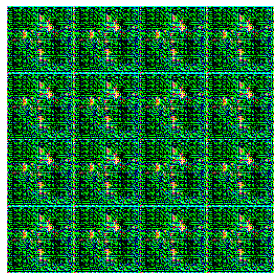

Epoch : 24000/50000  D-loss-Fake : 0.33042609691619873 D-loss :0.32104894518852234 G-loss : 0.40402358770370483 time_taken : 1 secs


In [ ]:
for step in range(num_steps): 
    tot_step = step
    step_begin_time = time.time() 
    
    real_data_X = sample_from_dataset(batch_size, image_shape, data_dir = data_dir)

    noise = gen_noise(batch_size,noise_shape)
    
    fake_data_X = generator.predict(noise)
    
    if tot_step % 1000 == 0:
        step_num = str(tot_step).zfill(4)
        save_img_batch(fake_data_X,img_save_dir+step_num+".png")

    #concatenate real and fake data samples    
    data_X = np.concatenate([real_data_X,fake_data_X])
    #add noise to the label inputs
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
    
    
    fake_data_Y = np.random.random_sample(batch_size)*0.2
     
    data_Y = np.concatenate((real_data_Y,fake_data_Y))
        
    discriminator.trainable = True
    generator.trainable = False
    #training the discriminator on real and fake data can be done together, i.e., 
    #on the data_x and data_y, OR it can be done 
    #one by one as performed below. This is the safer choice and gives better results 
    #as compared to combining the real and generated samples.
    dis_metrics_real = discriminator.train_on_batch(real_data_X,real_data_Y)  
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X,fake_data_Y)   
    
    
    
    avg_disc_fake_loss.append(dis_metrics_fake[0])
    avg_disc_real_loss.append(dis_metrics_real[0])
    
    generator.trainable = True

    GAN_X = gen_noise(batch_size,noise_shape)

    GAN_Y = real_data_Y
    
    discriminator.trainable = False
    
    gan_metrics = gan.train_on_batch(GAN_X,GAN_Y) 
    avg_GAN_loss.append(gan_metrics[0])
    
    
    end_time = time.time()
    diff_time = int(end_time - step_begin_time)
    if tot_step % 500 == 0:
        print(f"Epoch : {tot_step}/{num_steps}  D-loss-Fake : {dis_metrics_fake[0]} D-loss :{dis_metrics_real[0]} G-loss : {gan_metrics[0]} time_taken : {diff_time} secs")
    
    if ((tot_step+1) % 10000) == 0:
        print("-----------------------------------------------------------------")
        print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss)))    
        print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss)))    
        print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
        print("-----------------------------------------------------------------")
        discriminator.trainable = True
        generator.trainable = True
        generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch.hdf5")
        discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch.hdf5")